In [14]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

In [2]:
from HomoTopiContinuation.DataStructures.datastructures import Conic, Conics, Circle, Homography
from HomoTopiContinuation.SceneGenerator.scene_generator import SceneDescription, SceneGenerator

from HomoTopiContinuation.Rectifier.homotopyc_rectifier import HomotopyContinuationRectifier
from HomoTopiContinuation.ConicWarper.ConicWarper import ConicWarper

from HomoTopiContinuation.Losser.CircleLosser  import CircleLosser
from HomoTopiContinuation.Plotter.Plotter import Plotter

In [3]:
def sceneDefinition() -> SceneDescription:
    # Parameters
    f = 2
    theta = 30

    # Define the circles
    c1 = Circle(
        np.array([4, 4]), 1)
    c2 = Circle(
        np.array([3, 1]), 1)
    c3 = Circle(
        np.array([5, 1]), 1)

    print("Circle 1:")
    print(c1.to_conic().M)
    print([float(p) for p in c1.to_conic().to_algebraic_form()])
    print("Circle 2:")
    print(c2.to_conic().M)
    print([float(p) for p in c2.to_conic().to_algebraic_form()])
    print("Circle 3:")
    print(c3.to_conic().M)
    print([float(p) for p in c3.to_conic().to_algebraic_form()])

    offset = np.array([0, 0, 2])
    noiseScale = 0

    return SceneDescription(f, theta, offset, c1, c2, c3, noiseScale)

In [4]:
sceneDescription = sceneDefinition()

img = SceneGenerator().generate_scene(sceneDescription, debug=True)

H = img.h_true

Circle 1:
[[ 1  0 -4]
 [ 0  1 -4]
 [-4 -4 31]]
[1.0, 0.0, 1.0, -8.0, -8.0, 31.0]
Circle 2:
[[ 1  0 -3]
 [ 0  1 -1]
 [-3 -1  9]]
[1.0, 0.0, 1.0, -6.0, -2.0, 9.0]
Circle 3:
[[ 1  0 -5]
 [ 0  1 -1]
 [-5 -1 25]]
[1.0, 0.0, 1.0, -10.0, -2.0, 25.0]
No distortion params provided, using true conics


In [5]:
# compute the images of the circular points
I = np.array([1,1j,0])
J = np.array([1,-1j,0])

I_img = H.H @ I
J_img = H.H @ J

I_img = I_img / I_img[0]
J_img = J_img / J_img[0]

print(I_img)
print(J_img)


[1.+0.j        0.+0.8660254j 0.+0.25j     ]
[1.+0.j        0.-0.8660254j 0.-0.25j     ]


In [6]:
def perturb_circular_points(I_img, J_img, noise_scale):
    # Perturb the circular points
    I_img_perturbed = I_img + (np.random.normal(0, noise_scale, I_img.shape) + 1j*np.random.normal(0, noise_scale, I_img.shape))
    J_img_perturbed = J_img + (np.random.normal(0, noise_scale, J_img.shape) + 1j*np.random.normal(0, noise_scale, J_img.shape))
    return I_img_perturbed, J_img_perturbed


In [7]:
import tqdm
rectifier = HomotopyContinuationRectifier()
losser = CircleLosser

N_ITER = 100
N_PERTURBATION_STEPS = 500
losses = np.zeros(N_ITER * N_PERTURBATION_STEPS)
#perturbation_steps = np.linspace(1e-6, 1e-3, N_PERTURBATION_STEPS)
# logartimic scale
MINLOGDELTA = -9
MAXLOGDELTA = -1
perturbation_steps = np.logspace(MINLOGDELTA, MAXLOGDELTA, N_PERTURBATION_STEPS)
deltas = []
losses = []

warpedConicsHistory = []


for i, perturbation_scale in tqdm.tqdm(enumerate(perturbation_steps), total=N_PERTURBATION_STEPS, desc="Perturbation Scales"):
    for j in range(N_ITER):
        # get perturbed points
        I_img_perturbed, J_img_perturbed = perturb_circular_points(I_img, J_img, perturbation_scale)
        delta = [
            np.linalg.norm(I_img_perturbed - I_img),
            np.linalg.norm(J_img_perturbed - J_img)
        ]
        deltas.append(delta)
        # Apply SVD reconstruction starting from the perturbed points
        imDCCP = rectifier.compute_imDCCP_from_solutions(sols=np.array([I_img_perturbed, J_img_perturbed]))
        H_inv_computed = rectifier._compute_h_from_svd(imDCCP=imDCCP)
        # project the circles back
        warpedConics = ConicWarper().warpConics(img.C_img, H_inv_computed)
        warpedConicsHistory.append(warpedConics)
        loss = losser.computeCircleLoss(sceneDescription, warpedConics)
        #if (np.imag(np.max(loss)) < 1e-6):
        losses.append(loss)

losses = np.abs(np.array(losses))
deltas = np.array(deltas)

avgLoss = np.mean(losses, axis=-1)
avgDelta = np.mean(deltas, axis=-1)


Perturbation Scales: 100%|██████████| 500/500 [01:55<00:00,  4.34it/s]


In [8]:
np.max(losses), np.min(losses), np.mean(losses), np.std(losses)

(np.float64(9.486585705792699),
 np.float64(7.453515547607589e-06),
 np.float64(0.22730035282116204),
 np.float64(0.3374737785705571))

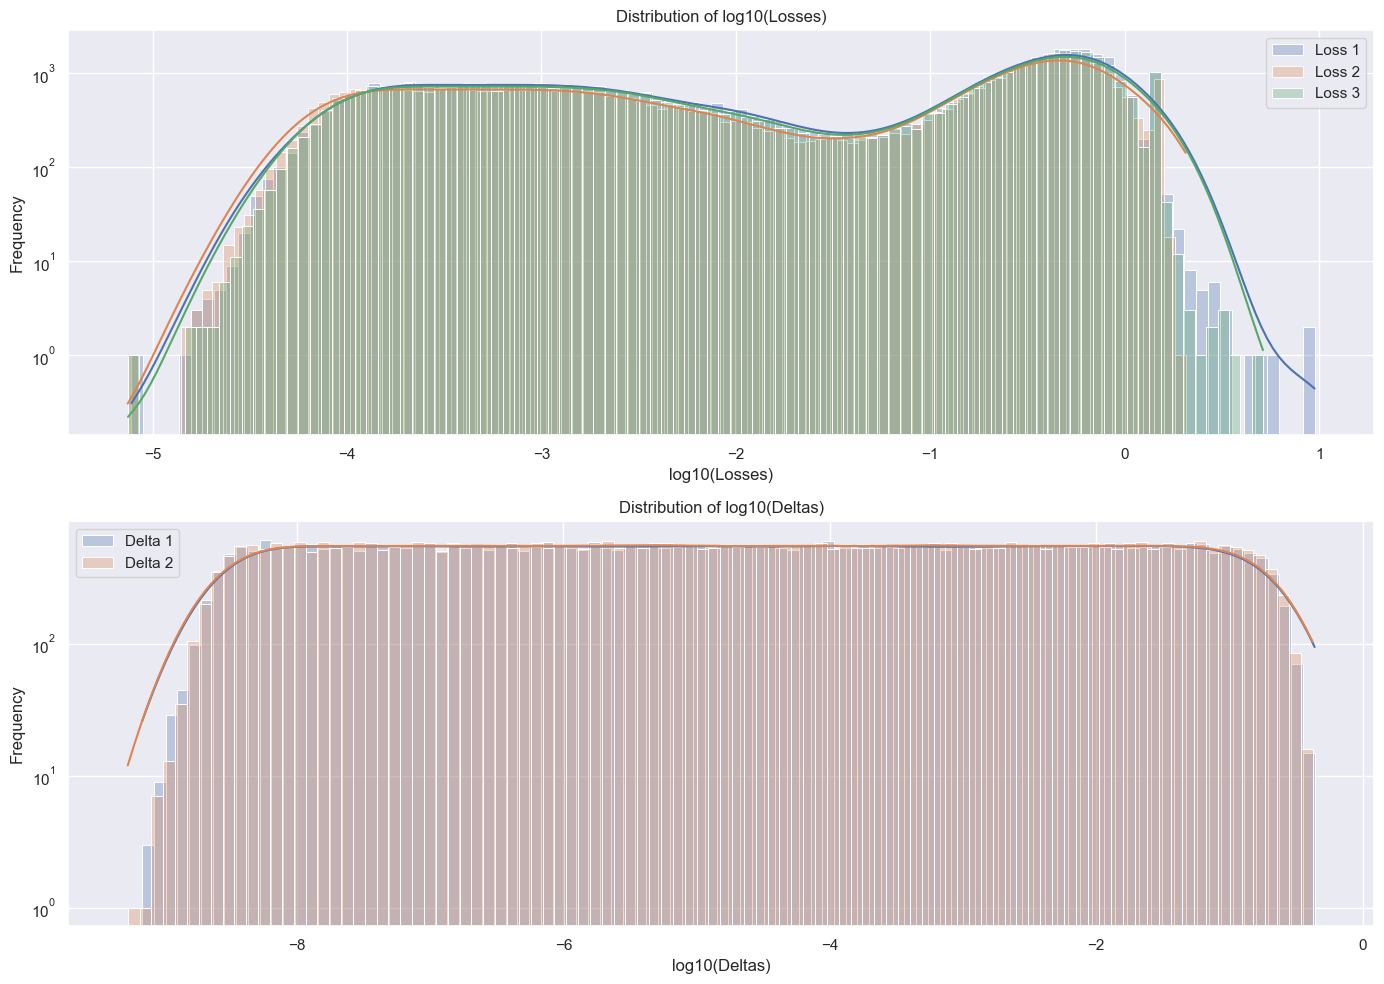

In [15]:
fig, axs = plt.subplots(2, 1, figsize=(14, 10))
for idx in range(losses.shape[1]):
    sns.histplot(np.log10(np.abs(losses[:, idx])), bins=100, alpha=0.3, label=f'Loss {idx+1}', kde=True, ax=axs[0])
axs[0].set_xlabel('log10(Losses)')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Distribution of log10(Losses)')
axs[0].set_yscale('log')
axs[0].legend()

for idx in range(deltas.shape[1]):
    sns.histplot(np.log10(np.abs(deltas[:, idx])), bins=100, alpha=0.3, label=f'Delta {idx+1}', kde=True, ax=axs[1])
axs[1].set_xlabel('log10(Deltas)')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Distribution of log10(Deltas)')
axs[1].set_yscale('log')
axs[1].legend()

plt.tight_layout()
plt.show()

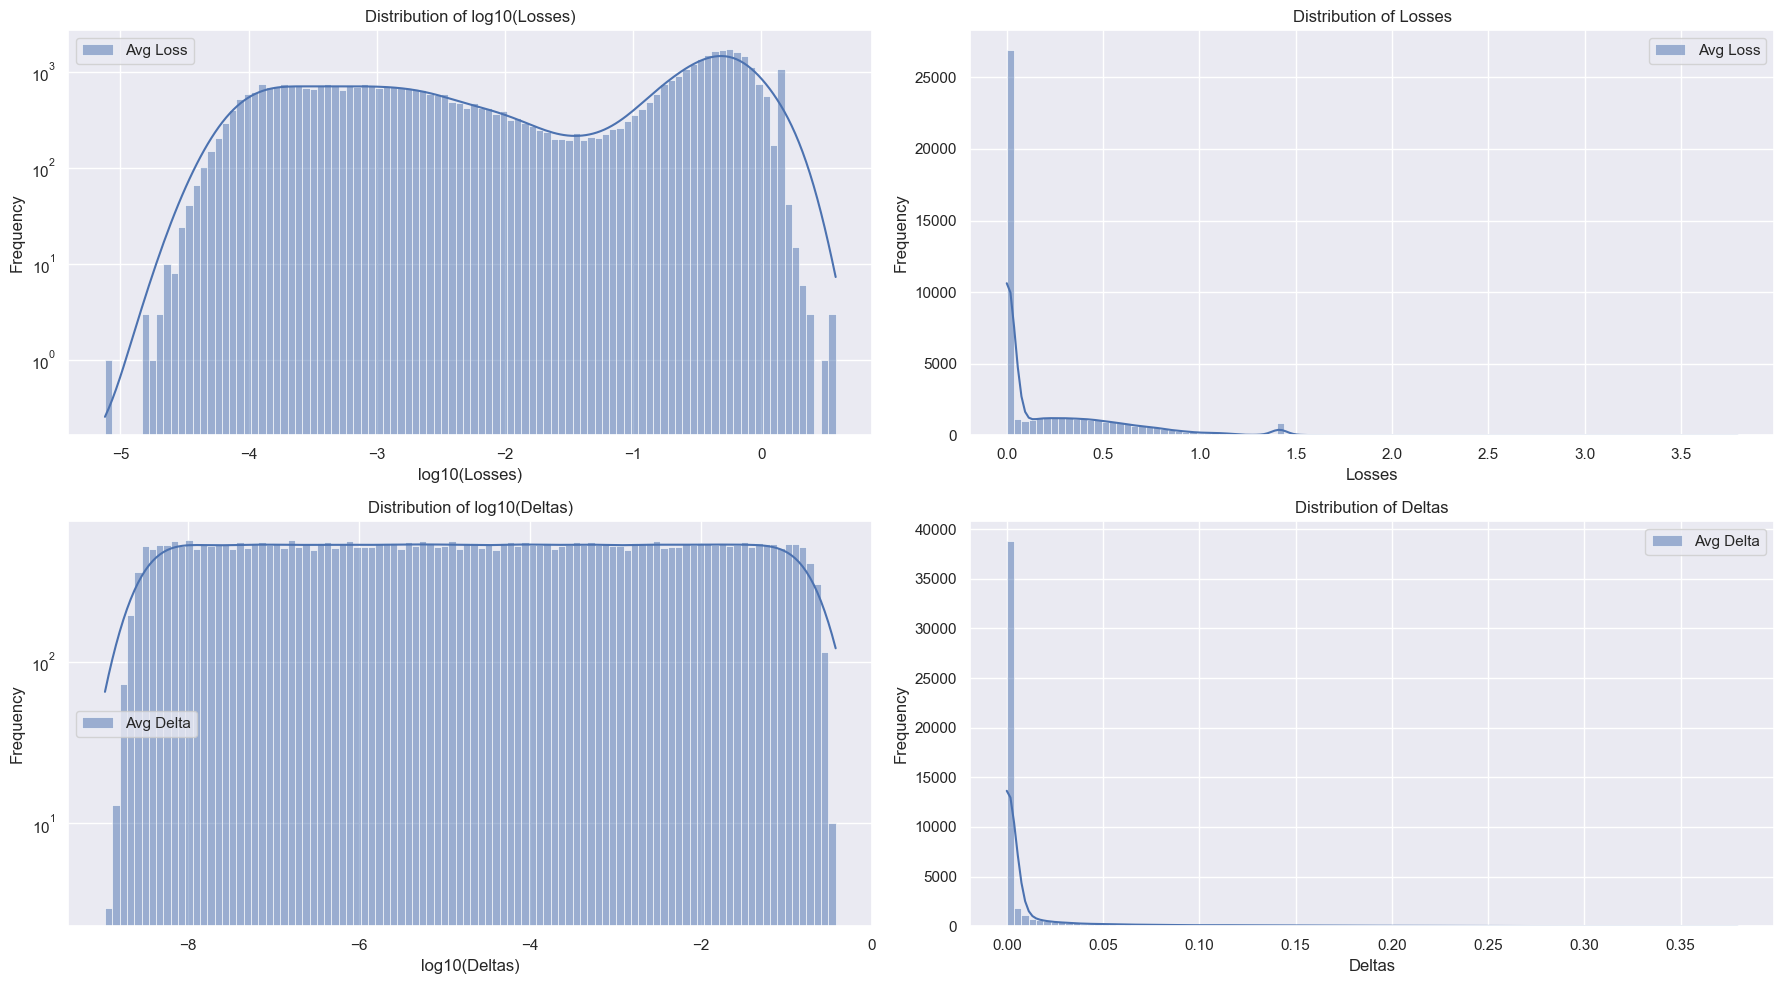

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(18, 10))

# Avg Loss - log10 x-axis
sns.histplot(np.log10(np.abs(avgLoss)), bins=100, label='Avg Loss', kde=True, ax=axs[0, 0])
axs[0, 0].set_xlabel('log10(Losses)')
axs[0, 0].set_ylabel('Frequency')
axs[0, 0].set_title('Distribution of log10(Losses)')
axs[0, 0].set_yscale('log')
axs[0, 0].legend()

# Avg Loss - linear x-axis
sns.histplot(np.abs(avgLoss), bins=100, label='Avg Loss', kde=True, ax=axs[0, 1])
axs[0, 1].set_xlabel('Losses')
axs[0, 1].set_ylabel('Frequency')
axs[0, 1].set_title('Distribution of Losses')
axs[0, 1].legend()

# Avg Delta - log10 x-axis
sns.histplot(np.log10(np.abs(avgDelta)), bins=100, label='Avg Delta', kde=True, ax=axs[1, 0])
axs[1, 0].set_xlabel('log10(Deltas)')
axs[1, 0].set_ylabel('Frequency')
axs[1, 0].set_title('Distribution of log10(Deltas)')
axs[1, 0].set_yscale('log')
axs[1, 0].legend()

# Avg Delta - linear x-axis
sns.histplot(np.abs(avgDelta), bins=100, label='Avg Delta', kde=True, ax=axs[1, 1])
axs[1, 1].set_xlabel('Deltas')
axs[1, 1].set_ylabel('Frequency')
axs[1, 1].set_title('Distribution of Deltas')
axs[1, 1].legend()

plt.tight_layout()
plt.show()

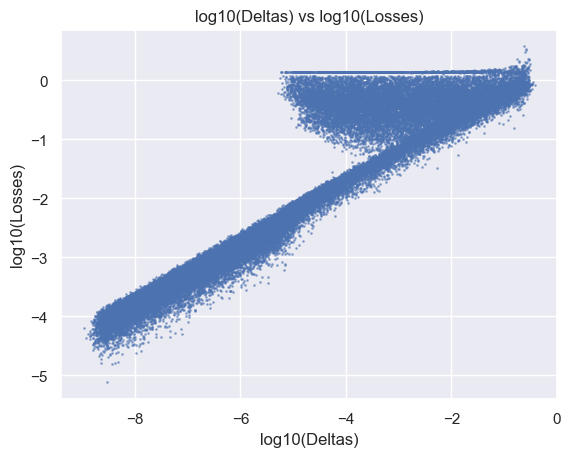

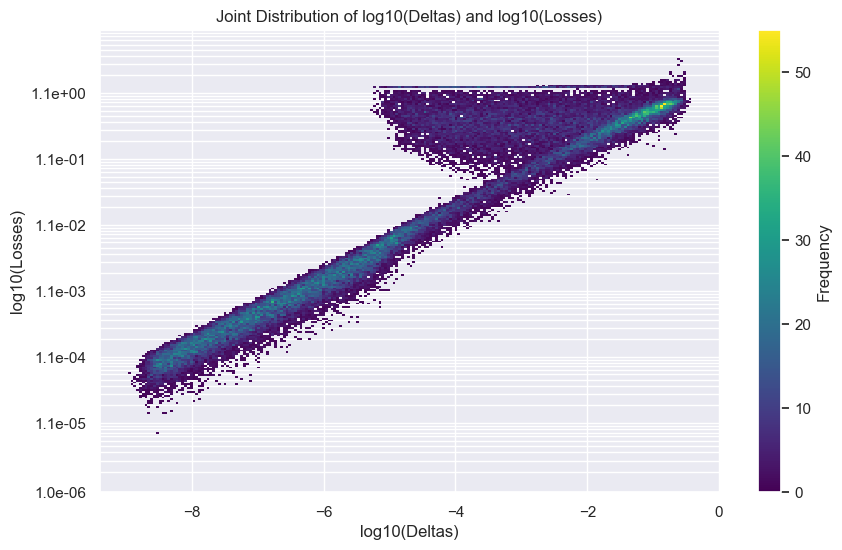

In [17]:
plt.Figure(figsize=(10, 6))
plt.scatter(np.log10(avgDelta), np.log10(avgLoss), alpha=0.5, s=1)
plt.xlabel('log10(Deltas)')
plt.ylabel('log10(Losses)')
plt.title('log10(Deltas) vs log10(Losses)')
plt.show()

# Plot the histogram of the joint distribution of deltas and losses
plt.figure(figsize=(10, 6))
sns.histplot(x=np.log10(avgDelta), y=np.log10(avgLoss), bins=200, cmap='viridis', cbar=True, cbar_kws={'label': 'Frequency'})
plt.xlabel('log10(Deltas)')
plt.ylabel('log10(Losses)')
plt.title('Joint Distribution of log10(Deltas) and log10(Losses)')
plt.grid(True, which='both', axis='both')
# Set grid lines at equally spaced intervals in linear space, then convert to log space
num_ticks = 10

# For y-axis (Losses)
ticks = np.linspace(0, 9, 10)
minLogDelta = -6
maxLogDelta = int(np.ceil(np.log10(np.max(avgDelta))))
exponents = np.linspace(minLogDelta, maxLogDelta, maxLogDelta - minLogDelta + 1)
basis = 10 ** exponents
basisCumSum = np.cumsum(basis)
shiftedTicks = np.concatenate([ticks * (10 ** e) + basisCumSum[i] for i, e in enumerate(exponents)])
y_ticks_log = np.log10(shiftedTicks)
plt.yticks(y_ticks_log, [f"{tick:.1e}" if (i)%10 == 0 else "" for i, tick in enumerate(shiftedTicks)])

plt.grid(True, which='both', axis='both')
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

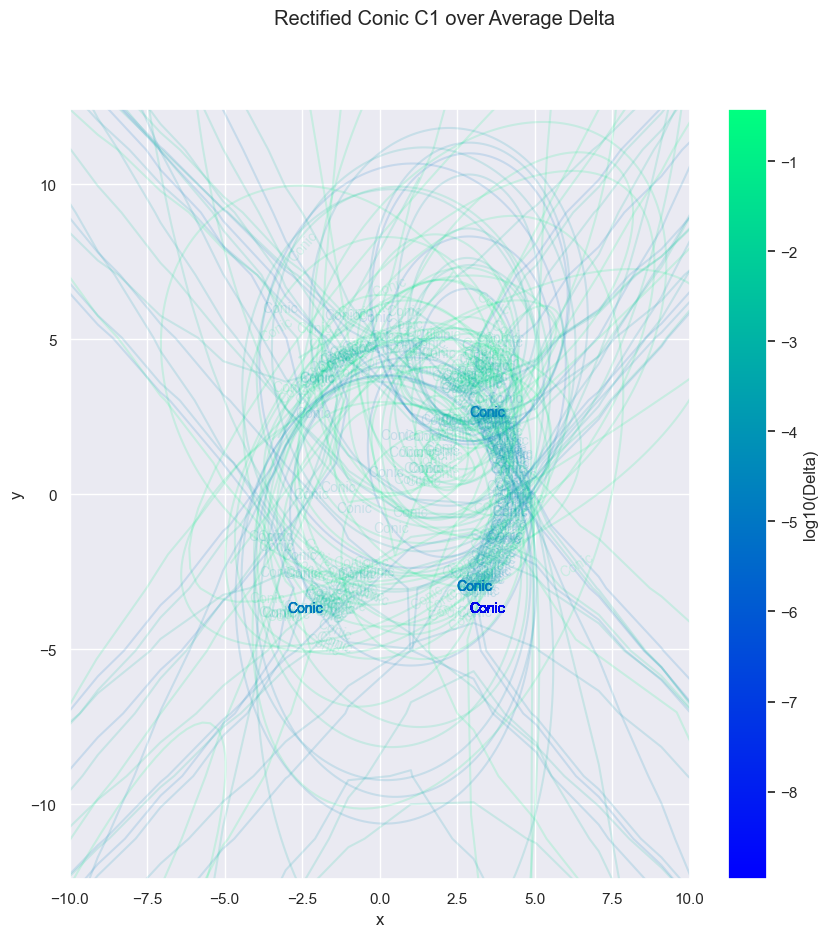

Done plotting warped conics.


In [18]:
from tqdm.notebook import tqdm
plotter = Plotter(1, 1, title="Rectified Conic C1 over Average Delta", figsize=(10, 10))
plotter.newAxis()

logDeltas = np.log10(np.abs(avgDelta))

plotN = 10000
plotEvery = 50  # Plot every nth iteration

palette = sns.color_palette("winter", as_cmap=True)
norm = plt.Normalize(logDeltas.min(), logDeltas.max())
colors = palette(norm(logDeltas[::-1][:plotN*plotEvery][::plotEvery]))

for idx, warpedConics in enumerate(tqdm(warpedConicsHistory[::-1][:plotN*plotEvery][::plotEvery], position=0)):
    color = colors[idx]
    conic = warpedConics.C1
    conic.M = np.real(conic.M)
    plotter.plotConic2D(conic, color=color, alpha=0.15)


ax = plotter.getCurrentAxis()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label='log10(Delta)')

plotter.show()
print("Done plotting warped conics.")
